In [1]:
using Pkg

In [2]:
Pkg.add("ScikitLearn")
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("PyCall")
Pkg.add("PyPlot");
Pkg.add("MultivariateStats");

   Updating registry at `C:\Users\conno\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\conno\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\conno\.julia\environme

In [3]:
using ScikitLearn
using DataFrames
using CSV
using PyCall
using PyPlot
using MultivariateStats

In [4]:
import ScikitLearn: CrossValidation

In [5]:
@sk_import decomposition: PCA;
@sk_import preprocessing: MinMaxScaler;
@sk_import neighbors: KNeighborsClassifier;
@sk_import svm: LinearSVC;

In [6]:
np = pyimport("numpy");

In [7]:
df = CSV.File("01_hdp.csv"; header = true) |> DataFrame;

In [8]:
X_df = [df.tumorsize df.co2 df.lungcapacity df.Age df.WBC df.RBC df.BMI df.IL6 df.CRP df.Medicaid];

In [9]:
y_df = df.CancerStage;

In [10]:
X = convert(Array, X_df);
y = convert(Array, y_df);

## Normalizing the data and then splitting it into testing and training

In [11]:
mms = MinMaxScaler();
X_norm = mms.fit_transform(X);

In [12]:
X_train, X_test, y_train, y_test = CrossValidation.train_test_split(X_norm, y, test_size=0.30);

# We are using the Sklearn PCA package first

## Creating and fitting the PCA models with the training data. Then transforming the training and testing data with the trained model (Sklearn PCA)

In [13]:
pca_models = [];
X_train_pca = [];
X_test_pca = [];
test_times = [];
for i in 1:10
    time = @elapsed begin
    push!(pca_models, PCA(n_components=i))
    pca_models[i].fit(X_train);
    push!(X_train_pca, pca_models[i].transform(X_train));
    end
    push!(test_times, time);
    push!(X_test_pca, pca_models[i].transform(X_test));
end

## Determining the amount of components needed to maintain 90% explained variance

In [14]:
cumV = np.cumsum(pca_models[10].explained_variance_ratio_);
nComp = 0;
for i in 1:10
    if(cumV[i] > 0.9)
        nComp = i+1;
        break;
    end
end

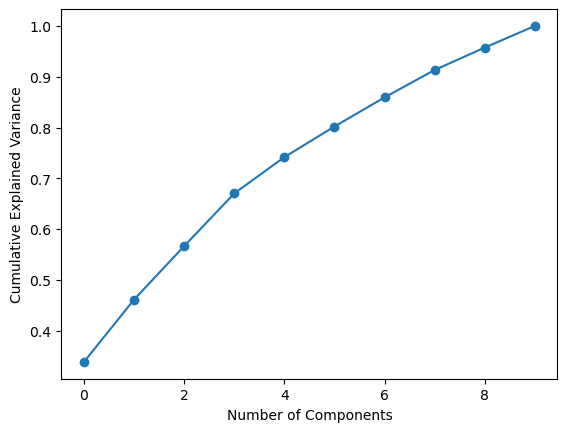

In [15]:
plt.plot(np.cumsum(pca_models[10].explained_variance_ratio_),"-o")
plt.xlabel("Number of Components");
plt.ylabel("Cumulative Explained Variance");

In [16]:
print("You need ", nComp, " principal components to preserve an explained varience of 90%");

You need 9 principal components to preserve an explained varience of 90%

## Using KNN and LinearSvc as my classifiers with the PCA data

In [17]:
neighbors = 450;
knn = KNeighborsClassifier(neighbors, metric="minkowski");
training_scores_knn = [];
testing_scores_knn = [];
for i in 1:10
    knn.fit(X_train_pca[i], y_train);
    train_score = knn.score(X_train_pca[i], y_train);
    test_score =  knn.score(X_test_pca[i], y_test);
    println("Training accuracy with ", neighbors, " neighbors with ",i, " PCA component is: ", train_score);
    println("Testing accuracy with ", neighbors, " neighbors with ",i, " PCA component is: ", test_score);
    println();
    push!(training_scores_knn, train_score);
    push!(testing_scores_knn, test_score);
end

Training accuracy with 450 neighbors with 1 PCA component is: 0.4045584045584046
Testing accuracy with 450 neighbors with 1 PCA component is: 0.3854573885848319

Training accuracy with 450 neighbors with 2 PCA component is: 0.40522875816993464
Testing accuracy with 450 neighbors with 2 PCA component is: 0.3885848318999218

Training accuracy with 450 neighbors with 3 PCA component is: 0.41025641025641024
Testing accuracy with 450 neighbors with 3 PCA component is: 0.41673182173573103

Training accuracy with 450 neighbors with 4 PCA component is: 0.41344058991117816
Testing accuracy with 450 neighbors with 4 PCA component is: 0.4175136825645035

Training accuracy with 450 neighbors with 5 PCA component is: 0.4154516507457684
Testing accuracy with 450 neighbors with 5 PCA component is: 0.4139953088350274

Training accuracy with 450 neighbors with 6 PCA component is: 0.43807608513490864
Testing accuracy with 450 neighbors with 6 PCA component is: 0.42885066458170445

Training accuracy with

In [18]:
svc = LinearSVC();
training_scores_svc = [];
testing_scores_svc = [];
for i in 1:10
    svc.fit(X_train_pca[i], y_train);
    train_score = svc.score(X_train_pca[i], y_train);
    test_score =  svc.score(X_test_pca[i], y_test);
    println("Training accuracy with ",i, " PCA component is: ", train_score);
    println("Testing accuracy with ",i, " PCA component is: ", test_score);
    println();
    push!(training_scores_svc, train_score);
    push!(testing_scores_svc, test_score);
end

Training accuracy with 1 PCA component is: 0.4047259929612871
Testing accuracy with 1 PCA component is: 0.3885848318999218

Training accuracy with 2 PCA component is: 0.4047259929612871
Testing accuracy with 2 PCA component is: 0.3885848318999218

Training accuracy with 3 PCA component is: 0.4115971174794704
Testing accuracy with 3 PCA component is: 0.4214229867083659

Training accuracy with 4 PCA component is: 0.41595441595441596
Testing accuracy with 4 PCA component is: 0.42415949960906957

Training accuracy with 5 PCA component is: 0.4152840623428859
Testing accuracy with 5 PCA component is: 0.42689601250977327

Training accuracy with 6 PCA component is: 0.4498072733366851
Testing accuracy with 6 PCA component is: 0.4464425332290852

Training accuracy with 7 PCA component is: 0.4519859225741579
Testing accuracy with 7 PCA component is: 0.45269741985926504

Training accuracy with 8 PCA component is: 0.4521535109770404
Testing accuracy with 8 PCA component is: 0.4515246286161063

Trai

## Plotting the PCA components vs. accuracy for the training and testing data sets (Sklearn PCA)

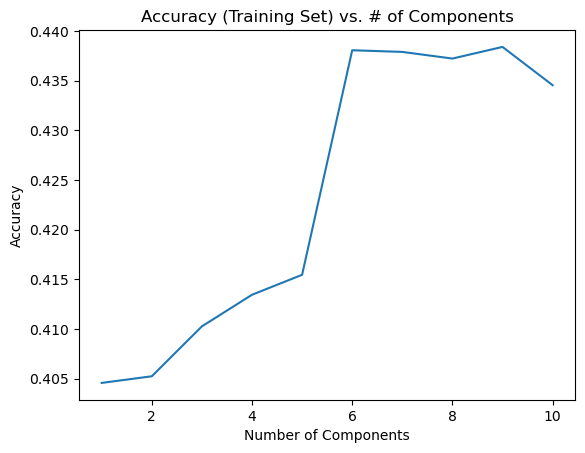

In [19]:
plt.plot(1:10, training_scores_knn);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Training Set) vs. # of Components");

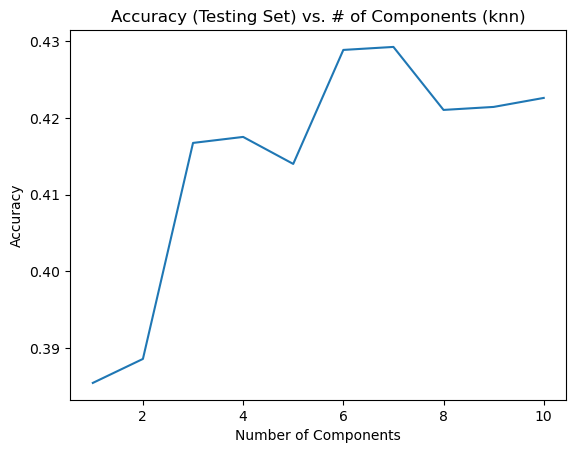

In [20]:
plt.plot(1:10, testing_scores_knn);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Testing Set) vs. # of Components (knn)");

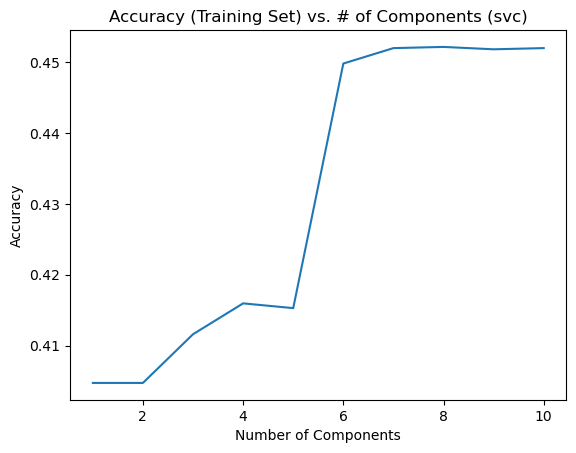

In [21]:
plt.plot(1:10, training_scores_svc);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Training Set) vs. # of Components (svc)");

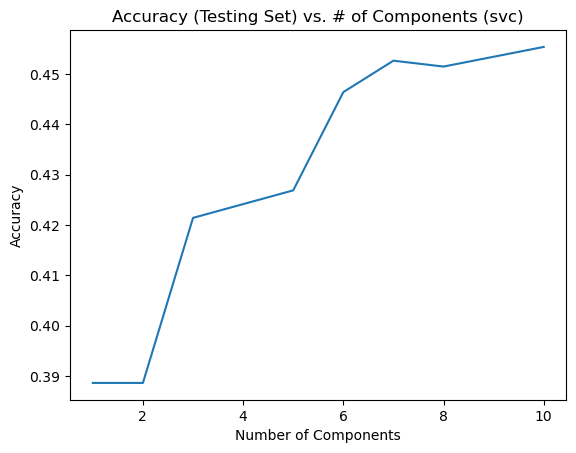

In [22]:
plt.plot(1:10, testing_scores_svc);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Testing Set) vs. # of Components (svc)");

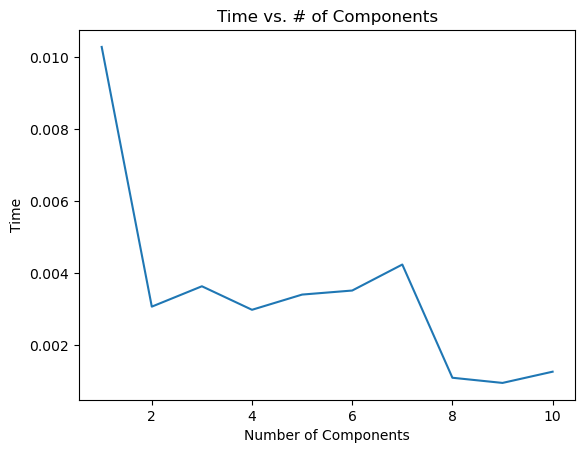

In [23]:
plt.plot(1:10, test_times);
plt.xlabel("Number of Components");
plt.ylabel("Time");
plt.title("Time vs. # of Components");

# Now we are using the Julia package for PCA

# Creating and fitting the PCA models with the training data. Then transforming the training and testing data with the trained model (Julia PCA)

In [24]:
pca_models_j = [];
X_test_pca_j = [];
X_train_pca_j = [];
test_times_j = [];
for i in 1:10
    time = @elapsed begin
    push!(pca_models_j, MultivariateStats.fit(MultivariateStats.PCA, X_train'; pratio=1, maxoutdim=i));
    push!(X_train_pca_j, MultivariateStats.transform(pca_models_j[i], X_train'));
    end
    push!(X_test_pca_j, MultivariateStats.transform(pca_models_j[i], X_test'));
    push!(test_times_j, time)
end

## Using KNN and LinearSvc as my classifiers with the PCA data

In [25]:
neighbors = 450;
knn = KNeighborsClassifier(neighbors, metric="minkowski");
training_scores_knn_j = [];
testing_scores_knn_j = [];
for i in 1:10
    knn.fit(X_train_pca_j[i]', y_train);
    train_score = knn.score(X_train_pca_j[i]', y_train);
    test_score =  knn.score(X_test_pca_j[i]', y_test);
    println("Training accuracy with ", neighbors, " neighbors with ",i, " PCA component is: ", train_score);
    println("Testing accuracy with ", neighbors, " neighbors with ",i, " PCA component is: ", test_score);
    println();
    push!(training_scores_knn_j, train_score);
    push!(testing_scores_knn_j, test_score);
end

Training accuracy with 450 neighbors with 1 PCA component is: 0.4045584045584046
Testing accuracy with 450 neighbors with 1 PCA component is: 0.3854573885848319

Training accuracy with 450 neighbors with 2 PCA component is: 0.40522875816993464
Testing accuracy with 450 neighbors with 2 PCA component is: 0.3885848318999218

Training accuracy with 450 neighbors with 3 PCA component is: 0.41025641025641024
Testing accuracy with 450 neighbors with 3 PCA component is: 0.41673182173573103

Training accuracy with 450 neighbors with 4 PCA component is: 0.41344058991117816
Testing accuracy with 450 neighbors with 4 PCA component is: 0.4175136825645035

Training accuracy with 450 neighbors with 5 PCA component is: 0.4154516507457684
Testing accuracy with 450 neighbors with 5 PCA component is: 0.4139953088350274

Training accuracy with 450 neighbors with 6 PCA component is: 0.43807608513490864
Testing accuracy with 450 neighbors with 6 PCA component is: 0.42885066458170445

Training accuracy with

In [26]:
svc = LinearSVC();
training_scores_svc_j = [];
testing_scores_svc_j = [];
for i in 1:10
    svc.fit(X_train_pca_j[i]', y_train);
    train_score = svc.score(X_train_pca_j[i]', y_train);
    test_score =  svc.score(X_test_pca_j[i]', y_test);
    println("Training accuracy with ",i, " PCA component is: ", train_score);
    println("Testing accuracy with ",i, " PCA component is: ", test_score);
    println();
    push!(training_scores_svc_j, train_score);
    push!(testing_scores_svc_j, test_score);
end

Training accuracy with 1 PCA component is: 0.4047259929612871
Testing accuracy with 1 PCA component is: 0.3885848318999218

Training accuracy with 2 PCA component is: 0.4047259929612871
Testing accuracy with 2 PCA component is: 0.3885848318999218

Training accuracy with 3 PCA component is: 0.4115971174794704
Testing accuracy with 3 PCA component is: 0.4214229867083659

Training accuracy with 4 PCA component is: 0.41595441595441596
Testing accuracy with 4 PCA component is: 0.42415949960906957

Training accuracy with 5 PCA component is: 0.4152840623428859
Testing accuracy with 5 PCA component is: 0.42689601250977327

Training accuracy with 6 PCA component is: 0.4498072733366851
Testing accuracy with 6 PCA component is: 0.4464425332290852

Training accuracy with 7 PCA component is: 0.4519859225741579
Testing accuracy with 7 PCA component is: 0.45269741985926504

Training accuracy with 8 PCA component is: 0.4521535109770404
Testing accuracy with 8 PCA component is: 0.4515246286161063

Trai

## Plotting the PCA components vs. accuracy for the training and testing data sets (Julia PCA)

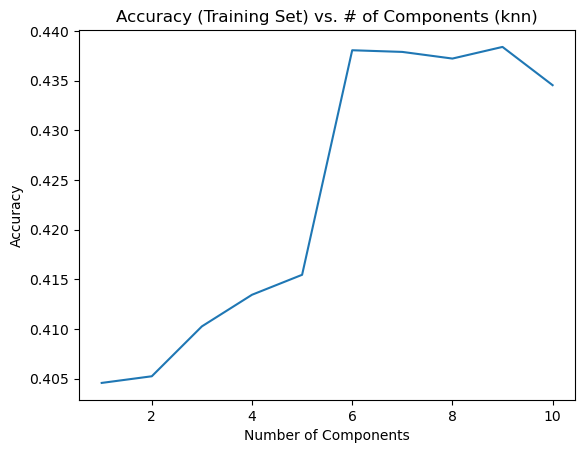

In [27]:
plt.plot(1:10, training_scores_knn_j);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Training Set) vs. # of Components (knn)");

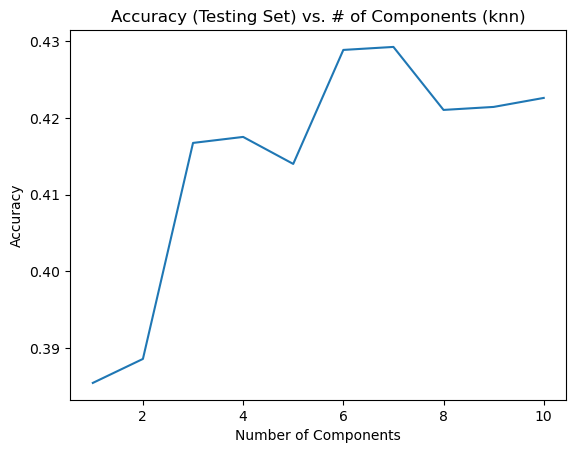

In [28]:
plt.plot(1:10, testing_scores_knn_j);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Testing Set) vs. # of Components (knn)");

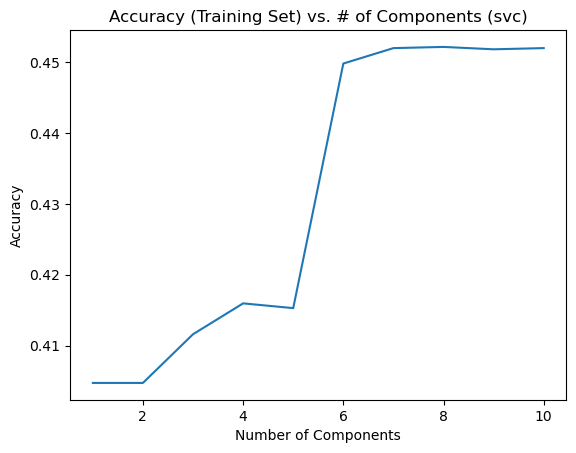

In [29]:
plt.plot(1:10, training_scores_svc_j);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Training Set) vs. # of Components (svc)");

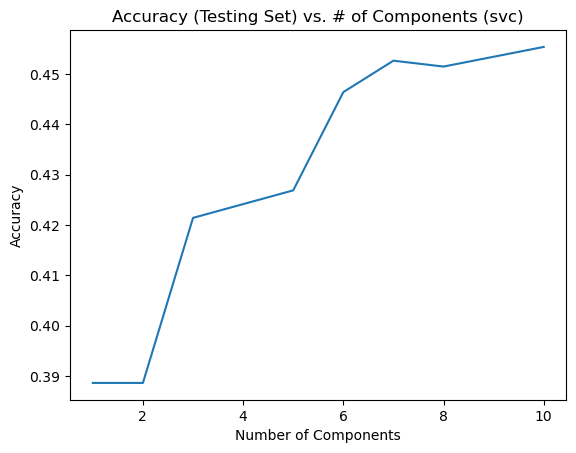

In [30]:
plt.plot(1:10, testing_scores_svc_j);
plt.xlabel("Number of Components");
plt.ylabel("Accuracy");
plt.title("Accuracy (Testing Set) vs. # of Components (svc)");

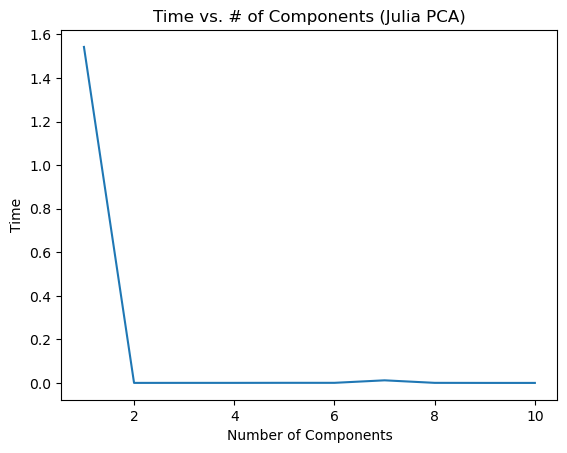

In [31]:
plt.plot(1:10, test_times_j);
plt.xlabel("Number of Components");
plt.ylabel("Time");
plt.title("Time vs. # of Components (Julia PCA)");